# 05. Differential Photometry

Here I will demonstrate differential photometry for single-filter observation, which we have from KMTNet.

From note 3, we learnt how to query sidereal objects and the asteroid. Here, I will show how to perform aperture photometry to the given field.

## 1. Importing and Setting Up
(You don't have to run the first code cell just below)

In [1]:
%load_ext version_information
import time
now = time.strftime("%Y-%m-%d %H:%M:%S (%Z = GMT%z)")
print(f"This notebook was generated at {now} ")

vv = %version_information astropy, numpy, scipy, matplotlib, astroquery, ccdproc, photutils, version_information
for i, pkg in enumerate(vv.packages):
    print(f"{i} {pkg[0]:10s} {pkg[1]:s}")

This notebook was generated at 2019-04-30 23:05:46 (KST = GMT+0900) 
0 Python     3.6.8 64bit [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
1 IPython    6.5.0
2 OS         Darwin 18.5.0 x86_64 i386 64bit
3 astropy    3.1.2
4 numpy      1.16.2
5 scipy      1.2.1
6 matplotlib 3.0.3
7 astroquery 0.3.9
8 ccdproc    1.3.0.post1
9 photutils  0.6
10 version_information 1.0.3


In [65]:
from pathlib import Path
import numpy as np

from astropy.io import fits
from astropy import units as u
from astropy.time import Time
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.visualization import ZScaleInterval, ImageNormalize
from astropy.stats import sigma_clipped_stats
from astropy.table import Table

from astroquery.vizier import Vizier
from astroquery.jplhorizons import Horizons

from photutils.aperture import CircularAperture as CAp
from photutils.aperture import CircularAnnulus as CAn
from photutils.detection import DAOStarFinder
from photutils.psf.groupstars import DAOGroup

from matplotlib import pyplot as plt
from matplotlib import rcParams

import warnings
warnings.filterwarnings('ignore', append=True, category=UserWarning)

from matplotlib import pyplot as plt

def znorm(image):
    return ImageNormalize(image, interval=ZScaleInterval())


def zimshow(ax, image, **kwargs):
    return ax.imshow(image, norm=znorm(image), origin='lower', **kwargs)


def panstarrs_query(ra_deg, dec_deg, rad_deg, columns=None, column_filters={},
                    maxsources=10000):
    """
    Query PanSTARRS @ VizieR using astroquery.vizier
    :param ra_deg: RA in degrees
    :param dec_deg: Declination in degrees
    :param rad_deg: field radius in degrees
    :param maxmag: upper limit G magnitude (optional)
    :param maxsources: maximum number of sources
    :return: astropy.table object
    Note
    ----
    All columns: http://vizier.u-strasbg.fr/viz-bin/VizieR?-source=II/349
    """
    if columns is None:
        columns = ['objID', 'RAJ2000', 'DEJ2000', 'e_RAJ2000', 'e_DEJ2000',
                   'gmag', 'e_gmag', 'rmag', 'e_rmag', 'imag', 'e_imag', 
                   'zmag', 'e_zmag', 'ymag', 'e_ymag']
    vquery = Vizier(columns=columns,
                    column_filters=column_filters,
                    row_limit=maxsources)

    field = SkyCoord(ra=ra_deg, dec=dec_deg,
                     unit=(u.deg, u.deg),
                     frame='icrs')
    return vquery.query_region(field,
                               width=("{}d".format(rad_deg)),
                               catalog="II/349/ps1")[0]


# Remove the next one line if you are not using Notebook (ipynb)
%matplotlib inline

plt.style.use('default')
rcParams.update({'font.size':12})

DATAPATH = Path('..') / 'data'

## 2. Load Data and Query

For details, please refer to note 03.

In [66]:
allfits = list(DATAPATH.glob("*.fits"))
allfits.sort()

hdul = fits.open(allfits[0])
hdr = hdul[0].header
data = hdul[0].data

# Set WCS and print for your information
w = WCS(hdr)

# Query object
objname = "4179"
observat = "B31"
t_obs = Time(hdr["DATE-OBS"]) + hdr["EXPTIME"] * u.s / 2
obj = Horizons(id=objname, location=observat, epochs=t_obs.jd)
obj_q = obj.ephemerides()

pos_sky = SkyCoord(obj_q["RA"][0], obj_q["DEC"][0], unit='deg')
pos_pix = pos_sky.to_pixel(wcs=w)

# Query sidereal objects (PS1)
image_center = np.array(hdul[0].shape) / 2 - 0.5
cent_coord = w.wcs_pix2world(image_center[0], image_center[1], 0)
# 0 means that we are using 0-indexing. You may use 1 for 1-indexing.

result = panstarrs_query(cent_coord[0], cent_coord[1], rad_deg=0.1,
                        column_filters={"gmag":"13.0..20.0", "e_gmag":"<0.10"})
pos_stars = SkyCoord(result["RAJ2000"], result["DEJ2000"], unit='deg')
pos_stars = pos_stars.to_pixel(wcs=w)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


## 3. Star Matching

There are two ways to match the star you queried above with the object visible in the image.
1. You can find **star-like** objects in the image automatically. 
2. Use the X Y coordinates from ``pos_stars`` above. Use it as the initial guess, and do centroiding at each position in the image.

The first way is useful when the image does not have catalogued stars. This happens when you analyze star clusters. The second way is useful when catalogued stars presend in the field of view. Here we will use the second method.

For each object of ``pos_stars``, we will do centroiding to find the exact position (center) of each star.

* From simple analysis, I found the FWHM of the point sources in the image is roughly 4 pixels. I will use this value throughout this note.
* I will set aperture radius to 1.5 FWHM $ \sim 1.5 \times 4 = 6$ pixels, and the inner and outer radii of annuli to be 4 and 6 FWHM, which are 16 and 24 pixels, respectively.

### 3-1. Drop Nearby Stars

There are stars which are close to each other. These stars should not be used. I here will use [DAOGroup](https://photutils.readthedocs.io/en/stable/grouping.html) of photutils, which uses the algorithm originally developed by P. Stetson in 1987.

The stars within ``crit_separation``, which I set as 6 times the FWHM (6 * 4 = 24 pixel), are regarded as "nearby stars" and grouped together.

In [68]:
fwhm = 4
daogroup = DAOGroup(crit_separation=6*fwhm)
star_groups = daogroup(Table(pos_stars, names=["x_0", "y_0"]))
star_groups.pprint(max_lines=100)

       x_0                y_0          id group_id
------------------ ------------------ --- --------
 431.2930760140192  86.47378776915866   1        1
 789.2193526223178  46.40956267672027   2        2
 515.6790029104372 131.42145048078783   3        3
 573.3793523634015  44.98107497460114   4        4
 734.3018163327216  185.6521180147347   5        5
 68.81213794018653  76.80370361529549   6        6
407.18677718557853 152.40600020735565   7        7
 150.9129316820961  62.00611912629665   8        8
100.02345920325676 311.08308555902113   9        9
 456.0222738078955  182.4758917948975  10       10
 273.7214362241896 314.13460705969646  11       11
  398.854526619455 428.71480076890475  12       12
367.67794306328153 259.38182949074053  13       13
355.89106801169123  450.6317775770822  14       14
 204.9528036980318  649.0317390584714  15       15
 836.1430025719619 351.47892839208816  16       16
 853.7890657991835 245.39584943175487  17       17
 684.6504621153441 352.02715774

* **TIP**: As explained in the documentation, the input of ``daogroup`` must be an astropy Table object with x/y coordinates in the column names of ``"x_0"`` and ``"y_0"``.

The stars with id 19 and 20 are grouped together because they were close to each other. We drop them:

In [83]:
pos_stars2 = star_groups.to_pandas().drop_duplicates("group_id", keep=False)
pos_stars2 = pos_stars2[["x_0", "y_0"]].to_numpy()
print(pos_stars2.shape)

(27, 2)


``.to_pandas()`` method changes astropy Table to pandas ``DataFrame``. The [``.drop_duplicate`` method](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop_duplicates.html) removes duplicated rows. I intentionally used ``pandas.DataFrame`` rather than ``astropy.Table``, because it is more common and widely used among python users.

The dropped list contains 27 stars, as expected. Drawing such 27 stars, you see:

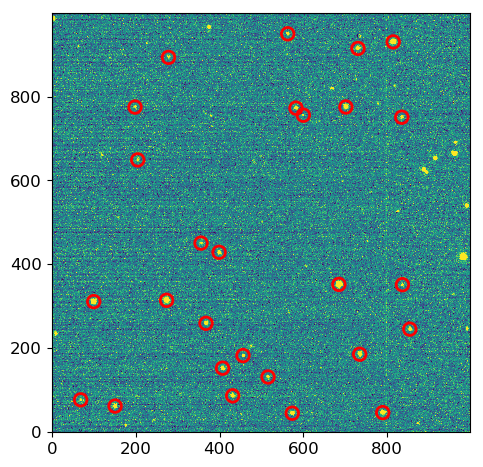

In [89]:
ap_stars = CAp(positions=pos_stars2, r=15)

fig, axs = plt.subplots(1, 1, figsize=(5, 6), sharex=False, sharey=False, gridspec_kw=None)
zimshow(axs, hdul[0].data)
ap_stars.plot(color='r', lw=2)
plt.tight_layout()

In [78]:
pos_stars2

(array([431.29307601, 789.21935262, 515.67900291, 573.37935236,
        734.30181633,  68.81213794, 407.18677719, 150.91293168,
        100.0234592 , 456.02227381, 273.72143622, 398.85452662,
        367.67794306, 355.89106801, 204.9528037 , 836.14300257,
        853.7890658 , 684.65046212, 893.28136522, 886.3364706 ,
        834.71148503, 582.2971792 , 599.8537514 , 701.22291716,
        278.3061817 , 198.41841314, 562.6115369 , 730.20938256,
        814.17274157]),
 array([ 86.47378777,  46.40956268, 131.42145048,  44.98107497,
        185.65211801,  76.80370362, 152.40600021,  62.00611913,
        311.08308556, 182.47589179, 314.13460706, 428.71480077,
        259.38182949, 450.63177758, 649.03173906, 351.47892839,
        245.39584943, 352.02715775, 619.45488423, 625.74451374,
        750.90905506, 772.53660529, 755.69146422, 775.26918219,
        893.56729952, 775.10363706, 949.72138636, 914.89029403,
        930.3986555 ]))